In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
from tqdm import tqdm
import glob
import pickle
from src.utils import get_cfg_from_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np
import re
import kornia
import torch.nn as nn
import scipy.signal
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt 
from pytorch_wavelets import DWTForward, DWTInverse


from src.utils import *
from src.model.autoencoder.AE_CNN_pool_2D import AE_CNN_pool_2D

In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
load_data = True

In [5]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [7]:
def explicit_ecs(ssp: torch.tensor,
                 depth_tens: torch.tensor,
                 tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    return ecs_pred

In [8]:
def get_ecs_ssp(ssp,z):
    
    ind = np.where(abs(np.diff(np.sign(np.diff(ssp)))) == 2)
    ind += np.ones((len(ind)))
    
    ssp_red = np.array([ssp[0],ssp[int(ind[0][0])]])
    z_red = z[int(ind[0][0])]
    
    return max(0, np.sign(ssp_red[1] - ssp_red[0]) * z_red)

In [9]:
def get_ecs_ssp_2D(ssp_2D,z):
    
    spatial_dim = ssp_2D.shape[-1]
    ecs = np.zeros(spatial_dim)
    for i in range (spatial_dim):
        ecs[i] = get_ecs_ssp(ssp_2D[:,i],z)
    
    return ecs

In [10]:
class LearnableGaussianBlur(nn.Module):
    def __init__(self, kernel_size, init_sigma=1.0):
        super(LearnableGaussianBlur, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = nn.Parameter(torch.tensor([init_sigma]))

    def forward(self, x):
        # Ensure sigma is positive
        sigma = torch.abs(self.sigma)
        # Apply the Gaussian blur using Kornia
        blurred = kornia.filters.gaussian_blur2d(x, (self.kernel_size, self.kernel_size), (sigma, sigma))
        return blurred

In [11]:
class LearnableGaussianKernel1d(nn.Module):
    def __init__(self, kernel_size, init_sigma=1.0, flip_tensor:bool = True):
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = torch.tensor([[init_sigma]])
        self.gausian_kernel = None
        self.flip_tensor = flip_tensor
        
    def forward(self, ssp_3D):
        
        ssp_3D = ssp_3D.permute((0,2,3,1))
        ssp_3D_shape = ssp_3D.shape
        ssp_depth = ssp_3D_shape[-1]
        
        ssp_flatten = ssp_3D.reshape(-1,ssp_depth)
        
        if self.flip_tensor:
            mirrored_ssp = torch.flip(ssp_flatten, dims=[1])
            ssp_flatten = torch.cat((mirrored_ssp, ssp_flatten, mirrored_ssp), dim=1)            
        
        
        self.gausian_kernel = kornia.filters.get_gaussian_kernel1d(self.kernel_size, self.sigma) 
        pad = (self.kernel_size-1)//2
        ssp_filtered = F.conv1d(ssp_flatten.unsqueeze(1), weight= self.gausian_kernel.view(1,1,-1).to(ssp_flatten.device), padding=pad).squeeze(dim=1)
        
        if self.flip_tensor:
            ssp_filtered = ssp_filtered[:,ssp_depth:2*ssp_depth]
        
        ssp_3D_filtered = ssp_filtered.reshape(ssp_3D_shape).permute((0,3,1,2))
        
        
        return ssp_3D_filtered
        
        

In [12]:
def unorm_ssp(ssp_3D_tensor, dm):
    if dm.norm_stats.method == "mean_std_along_depth":
        mean,std = dm.norm_stats.params.values()
        unorm_ssp = (ssp_3D_tensor.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1)

        
    elif dm.norm_stats.method == "mean_std":
        mean,std = dm.norm_stats.params.values()
        unorm_ssp = ssp_3D_tensor.detach().cpu().numpy()*std+ mean
        
    elif dm.norm_stats.method == "min_max":
        x_min,x_max = dm.norm_stats.params.values()
        unorm_ssp = ssp_3D_tensor.detach().cpu().numpy()*(x_max-x_min) + x_min
        
    return unorm_ssp

In [13]:
#model = f"latent_dim_{n_components}_pooling_1_None"
#ckpt_path = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AfromE_CNN_pool_2D/pred_1_var_0_gradient_1000_ecs_0/latent_dim_{n_components}_pooling_1_None_dropout_0.2/None/**/*.ckpt",recursive=True)[-1]

#ckpt_path = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_3D/pred_1_var_0_ecs_100/latent_dim_{n_components}_num_layers_5_linear_True/None/**/*.ckpt",recursive=True)[0]
#ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_5/None/2024-08-01_12-34/checkpoints/val_loss=0.01-epoch=18.ckpt"
ckpt_path ="/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_5/None/2024-07-17_13-35/checkpoints/val_loss=0.01-epoch=04.ckpt"
print(ckpt_path)

/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_5/None/2024-07-17_13-35/checkpoints/val_loss=0.01-epoch=04.ckpt


In [14]:
match = re.search(r"latent_dim_(\d+)", ckpt_path)

# Extract the number
if match:
    n_components = int(match.group(1))

else:
    print("No match found")
    
n_components

9

In [15]:
cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  norm_stats: {method: mean_std_along_depth, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 2D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  loss_weight: {ecs_weight: 0, gradient_weight: 0, prediction_weight: 1, variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN_pool
model_config:
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  model_hparams:
    AE_CNN_2D:
      act_fn_str: None
      base_channels: 107
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_3D:
      act_fn_str: None
      base_channels: 1
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_pool_2D:
      act_fn_str: None
      dropout_proba: 0
      dtype_str: float32
      final_act_fn_str: None
      init_params:
        params: {_target_: src.utils.get_convo_init_weight_bias, init_params_pickle_path: "/homes/o23gauvr/Documents/th\xE8\
            se/code/FASCINATION/pickle/pca_mean_and_components.pkl"}
        use: true
      input_channels: 107
      latent_dim: 9
      num_layers: 1
      pooling_str: None
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  save_dir:
    AE_CNN: {version: 'latent_dim_${model.model_hparams.latent_dim}_num_layers_${model.model_hparams.num_layers}_linear_${model.model_hparams.linear_layer}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
    AE_CNN_pool: {version: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
normalization:
  mean_std: {mean: 1513.8417292146794, std: 14.949060449731395}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
patience: 5
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: '${patience}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_var_${model.loss_weight.variation_weight}_gradient_${model.loss_weight.gradient_weight}_ecs_${model.loss_weight.ecs_weight}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/AE_V2/",
    version: '${model_config.save_dir.${model_architecture}.version}'}
  max_epochs: 1000
  min_epochs: 0


```

In [17]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api


UnboundLocalError: cannot access local variable 'train_data_array' where it is not associated with a value

In [ ]:
depth_array = dm.test_dataloader().dataset.input.z.data

In [ ]:
test_ssp_ds = dm.test_dataloader().dataset.input
test_ssp_ds_drop_na = test_ssp_ds.dropna(dim='lat')
#test_ssp_ds_drop_na = test_ssp_ds.fillna(0)
test_ssp_arr = test_ssp_ds_drop_na.data
test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
input_test_shape = test_ssp_arr.shape

In [ ]:
coords = test_ssp_ds_drop_na.coords

In [ ]:
lit_model = load_model(ckpt_path, device)
ssp_pred = lit_model(test_ssp_tens)

In [ ]:
print(dm.norm_stats.method)

if dm.norm_stats.method == "mean_std_along_depth":
    mean,std = dm.norm_stats.params.values()
    ssp_truth_unorm_test_arr = (test_ssp_tens.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1) 
    ssp_ae_unorm_test_arr = (ssp_pred.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1)
    
elif dm.norm_stats.method == "mean_std":
    mean,std = dm.norm_stats.params.values()
    ssp_truth_unorm_test_arr = test_ssp_tens.detach().cpu().numpy()*std + mean
    ssp_ae_unorm_test_arr = ssp_pred.detach().cpu().numpy()*std+ mean
    
elif dm.norm_stats.method == "min_max":
    x_min,x_max = dm.norm_stats.params.values()
    ssp_truth_unorm_test_arr = test_ssp_tens.detach().cpu().numpy()*(x_max-x_min) + x_min
    ssp_ae_unorm_test_arr = ssp_pred.detach().cpu().numpy()*(x_max-x_min) + x_min

mean_std_along_depth


In [ ]:
ecs_truth = explicit_ecs(torch.tensor(ssp_truth_unorm_test_arr).float(),torch.tensor(depth_array).float()).to(device)
ecs_pred_ae = explicit_ecs(torch.tensor(ssp_ae_unorm_test_arr).float(),torch.tensor(depth_array).float()).to(device)

In [ ]:
t = 30
lat = 17
lon = 15

# Gaussuan Blur

In [ ]:
gaussian_filter_1D = LearnableGaussianKernel1d(kernel_size = 15, init_sigma=7., flip_tensor=True)
#gaussian_filter_1D = LearnableGaussianKernel1d_no_flip(kernel_size = 3, init_sigma=0.1)
#filtered_ssp_test = gaussian_filter_1D(torch.tensor(ssp_ae_unorm_test_arr).float().to(device))
filtered_ssp_test = gaussian_filter_1D(torch.tensor(ssp_pred).float().to(device)) 


/tmp/ipykernel_1470343/3749703262.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filtered_ssp_test = gaussian_filter_1D(torch.tensor(ssp_pred).float().to(device))


In [ ]:
if dm.norm_stats.method == "mean_std_along_depth":
    mean,std = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = (filtered_ssp_test.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1)

    
elif dm.norm_stats.method == "mean_std":
    mean,std = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = filtered_ssp_test.detach().cpu().numpy()*std+ mean
    
elif dm.norm_stats.method == "min_max":
    x_min,x_max = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = filtered_ssp_test.detach().cpu().numpy()*(x_max-x_min) + x_min

In [ ]:
gaussian_filter_1D.gausian_kernel

tensor([[0.0482, 0.0551, 0.0616, 0.0676, 0.0726, 0.0764, 0.0787, 0.0795, 0.0787,
         0.0764, 0.0726, 0.0676, 0.0616, 0.0551, 0.0482]])

In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

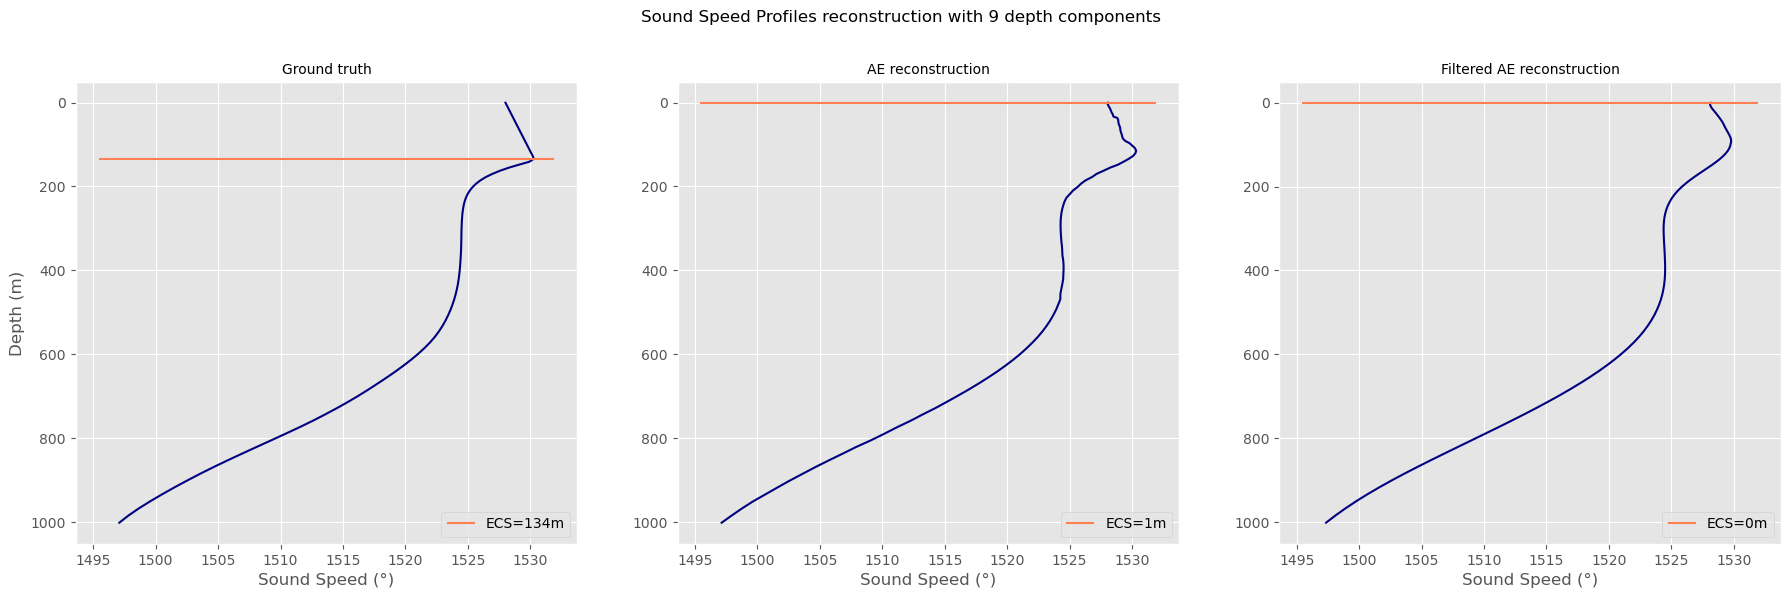

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(unorm_filtered_ssp_test[t,:,lat,lon], depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

In [ ]:
filtered_2D_ssp = kornia.filters.gaussian_blur2d(torch.tensor(ssp_ae_unorm_test_arr[t,:,lat,:]).unsqueeze(0).unsqueeze(0), (3, 3), (1.5, 10)).squeeze().detach().numpy()

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

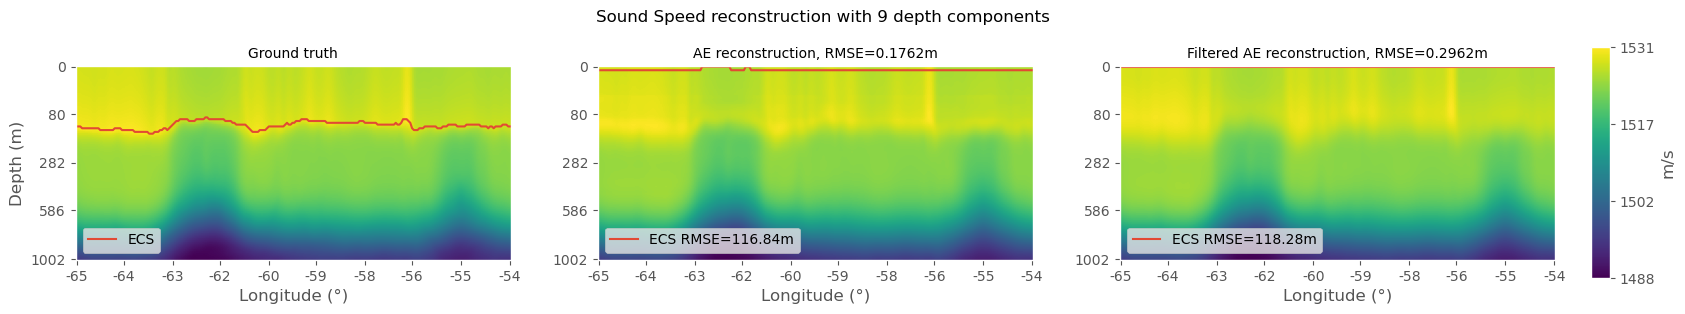

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)),4)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)),4)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)

In [ ]:
kernel_list = [2*k+1 for k in range(30)]
sigma_list = [0.1*s**2 for s in range(15)]


In [ ]:
if dm.norm_stats.method == "mean_std_along_depth":
    mean,std = dm.norm_stats.params.values()
    unorm_ssp_test = (ssp_pred.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1)

    
elif dm.norm_stats.method == "mean_std":
    mean,std = dm.norm_stats.params.values()
    unorm_ssp_test = ssp_pred.detach().cpu().numpy()*std+ mean
    
elif dm.norm_stats.method == "min_max":
    x_min,x_max = dm.norm_stats.params.values()
    unorm_ssp_test = ssp_pred.detach().cpu().numpy()*(x_max-x_min) + x_min

In [ ]:
ecs_pred_ae_filtered

tensor([[[8.0691e-06, 1.2561e-05, 3.3396e+01,  ..., 5.6796e+01,
          5.2484e+01, 5.2484e+01],
         [2.6909e+01, 2.6909e+01, 3.3396e+01,  ..., 5.2484e+01,
          5.2484e+01, 4.4355e+01],
         [2.6909e+01, 3.3396e+01, 3.3396e+01,  ..., 5.6796e+01,
          5.2484e+01, 4.8337e+01],
         ...,
         [0.0000e+00, 0.0000e+00, 1.7759e-06,  ..., 4.4399e-06,
          5.5542e-06, 1.0968e-05],
         [0.0000e+00, 0.0000e+00, 1.7759e-06,  ..., 0.0000e+00,
          8.0691e-06, 9.4702e-06],
         [0.0000e+00, 0.0000e+00, 1.7759e-06,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[9.4702e-06, 1.0968e-05, 9.4702e-06,  ..., 1.9906e-05,
          2.8811e-05, 1.4252e-05],
         [2.8811e-05, 2.6438e-05, 1.4252e-05,  ..., 2.4162e-05,
          1.2561e-05, 5.5542e-06],
         [1.4252e-05, 1.2561e-05, 1.6039e-05,  ..., 1.0968e-05,
          2.1985e-05, 2.1985e-05],
         ...,
         [0.0000e+00, 0.0000e+00, 1.7759e-06,  ..., 6.7639e-06,
          6.763

In [ ]:
unorm_filtered_ssp_test

tensor([[[[1533.7517, 1533.7356, 1533.5803,  ..., 1532.0154, 1531.8036,
           1531.5521],
          [1533.8441, 1533.8284, 1533.6853,  ..., 1532.0804, 1531.8854,
           1531.6104],
          [1534.0099, 1533.9586, 1533.8440,  ..., 1531.6997, 1531.5372,
           1531.3104],
          ...,
          [1436.1256, 1436.1256, 1436.1256,  ..., 1497.2864, 1497.5566,
           1497.6261],
          [1436.1256, 1436.1256, 1436.1256,  ..., 1496.6743, 1497.2509,
           1497.2023],
          [1436.1256, 1436.1256, 1436.1256,  ..., 1496.4763, 1497.2462,
           1497.0223]],

         [[1533.7716, 1533.7552, 1533.6008,  ..., 1532.0078, 1531.7963,
           1531.5449],
          [1533.8660, 1533.8499, 1533.7076,  ..., 1532.0725, 1531.8774,
           1531.6029],
          [1534.0344, 1533.9839, 1533.8699,  ..., 1531.6948, 1531.5321,
           1531.3051],
          ...,
          [1435.9856, 1435.9856, 1435.9856,  ..., 1497.3113, 1497.5614,
           1497.6305],
          [1435.98

In [ ]:
min_rmse = 1000
min_kernel = 0
min_sigma = 0

for kernel in tqdm(kernel_list, desc="kernel loop"):
    for sigma in tqdm(sigma_list, desc="sigma loop"):
        

        gaussian_filter_1D = LearnableGaussianKernel1d(kernel_size = kernel, init_sigma=sigma, flip_tensor=True)
        unorm_filtered_ssp_test = gaussian_filter_1D(torch.tensor(unorm_ssp_test).float().to(device)) 
        
        ecs_pred_ae_filtered = explicit_ecs(unorm_filtered_ssp_test.float(),torch.tensor(depth_array).float().to(device))
        
        
        rmse_ecs = torch.sqrt(torch.mean((ecs_pred_ae_filtered-ecs_truth)**2))
        
        if rmse_ecs < min_rmse:
            min_rmse = rmse_ecs
            min_kernel = kernel
            min_sigma = sigma

print("min rmse on ecs", min_rmse)
print("min kernel", min_kernel)
print("min sigma", min_sigma)

kernel loop:  63%|██████▎   | 19/30 [1:24:51<48:13, 263.07s/it]

# Pool & Upsample

In [ ]:
ssp_pred.shape

torch.Size([36, 107, 240, 240])

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

In [ ]:
ssp_flatten.shape

torch.Size([2073600, 107])

In [ ]:
ssp_flatten_pool = F.max_pool1d(ssp_flatten.unsqueeze(1),kernel_size=3, stride=1)
ssp_flatten_pool.shape

torch.Size([2073600, 1, 98])

In [ ]:
ssp_flatten_pool_upsample = F.interpolate(ssp_flatten_pool,107).squeeze(1)
ssp_flatten_pool_upsample.shape

torch.Size([2073600, 107])

In [ ]:
ssp_3D_filtered = ssp_flatten_pool_upsample.reshape(ssp_3D_shape).permute((0,3,1,2))
ssp_3D_filtered.shape

torch.Size([36, 107, 240, 240])

In [ ]:
if dm.norm_stats.method == "mean_std_along_depth":
    mean,std = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = (ssp_3D_filtered.detach().cpu().numpy()*std.data.reshape(1,-1,1,1)) + mean.data.reshape(1,-1,1,1)

    
elif dm.norm_stats.method == "mean_std":
    mean,std = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = ssp_3D_filtered.detach().cpu().numpy()*std+ mean
    
elif dm.norm_stats.method == "min_max":
    x_min,x_max = dm.norm_stats.params.values()
    unorm_filtered_ssp_test = ssp_3D_filtered.detach().cpu().numpy()*(x_max-x_min) + x_min

In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

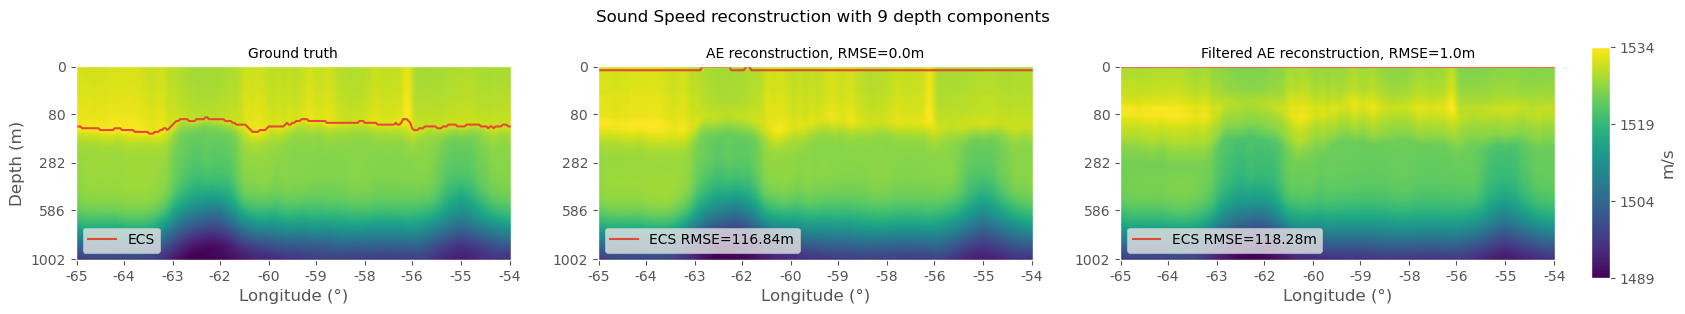

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int))
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)))}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)))}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)

In [ ]:
unorm_filtered_ssp_test.shape
ind = np.where(abs(np.diff(np.sign(np.diff(unorm_filtered_ssp_test[t,:,lat,lon])))) == 2)
ind += np.ones((len(ind)))
ind

array([[ 2., 11., 12., 23., 24., 26., 55., 59., 60., 63., 66., 67.]])

Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

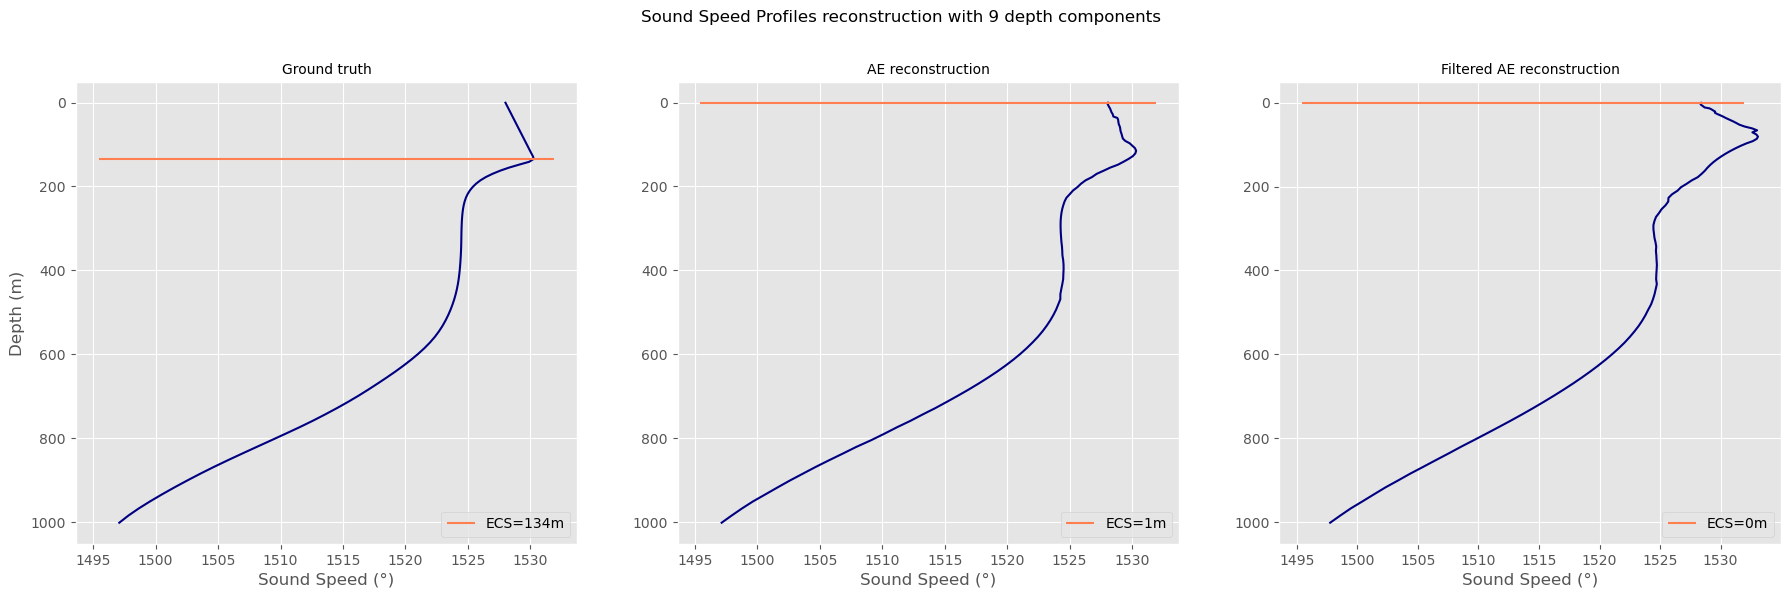

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(unorm_filtered_ssp_test[t,:,lat,lon], depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  ecs_pred_ae_filtered[t,lat,lon].detach().cpu().numpy() #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

# Kornia 2D filter

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

ssp_flatten = ssp_flatten.unsqueeze(dim=1).unsqueeze(dim=-1)
ssp_flatten.shape

torch.Size([2073600, 1, 107, 1])

In [ ]:
ssp_flatten_blur = kornia.filters.median_blur(ssp_flatten, kernel_size=(3,1))[:,0,:,0].squeeze()
ssp_3D_blur = ssp_flatten_blur.reshape(ssp_3D_shape).permute((0,3,1,2))

unorm_ssp_3D_blur = unorm_ssp(ssp_3D_blur,dm)
unorm_ssp_3D_blur.shape

(36, 107, 240, 240)

In [ ]:
# ssp_flatten_laplacian = kornia.filters.laplacian(ssp_flatten.repeat(1,1,1,3), kernel_size = (9,1), border_type='reflect', normalized=True)[:,0,:,0].squeeze()

# ssp_3D_laplacian = ssp_flatten_laplacian.reshape(ssp_3D_shape).permute((0,3,1,2))

# unorm_ssp_3D_laplacian = unorm_ssp(ssp_3D_laplacian,dm)
# unorm_ssp_3D_laplacian.shape


In [ ]:
# ssp_flatten_max_pool = kornia.filters.max_blur_pool2d(ssp_flatten.repeat(1,1,1,3), kernel_size=9, stride=2, max_pool_size=2, ceil_mode=True)
# ssp_flatten_max_pool = F.interpolate(ssp_flatten_max_pool,size = (107,3))[:,0,:,0].squeeze()
# ssp_3D_max_pool = ssp_flatten_max_pool.reshape(ssp_3D_shape).permute((0,3,1,2))

# unorm_ssp_3D_max_pool = unorm_ssp(ssp_3D_max_pool,dm)
# unorm_ssp_3D_max_pool.shape

In [ ]:
ssp_flatten_unsharp = kornia.filters.unsharp_mask(ssp_flatten, kernel_size = (51,1), sigma = (8,1), border_type='reflect')[:,0,:,0].squeeze()

ssp_3D_unsharp = ssp_flatten_unsharp.reshape(ssp_3D_shape).permute((0,3,1,2))

unorm_ssp_3D_unsharp = unorm_ssp(ssp_3D_unsharp,dm)

unorm_ssp_3D_unsharp.shape

(36, 107, 240, 240)

Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

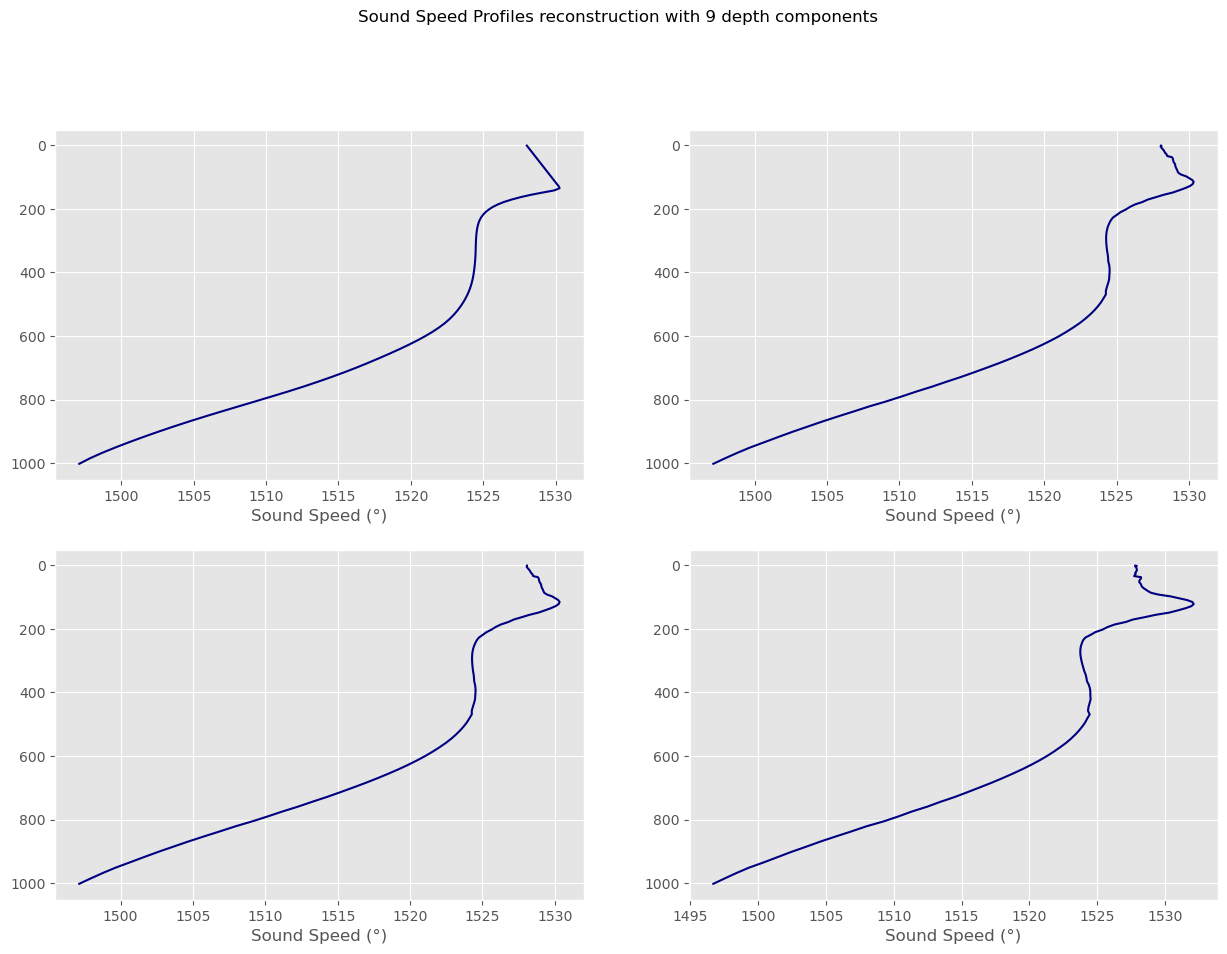

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(15,10))


im1 = axs[0,0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[0,1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[1,0].plot(unorm_ssp_3D_blur[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[1,1].plot(unorm_ssp_3D_unsharp[t,:,lat,lon], depth_array, c ="navy")

# im3 = axs[1,1].plot(unorm_ssp_3D_max_pool[t,:,lat,lon], depth_array, c ="navy")
# im3 = axs[2,0].plot(unorm_ssp_3D_laplacian[t,:,lat,lon], depth_array, c ="navy")



# xmin, xmax = axs[0].get_xlim()
# ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
# ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
# ecs_pred_filtered_ssp =  ecs_pred_ae_filtered[t,lat,lon].detach().cpu().numpy() #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


# axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
# axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
# axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs.flatten():

    #ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

# axs[0].set_title("Ground truth", fontsize = 10)
# axs[1].set_title("AE reconstruction", fontsize = 10)
# axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



#axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

# Scipy signal Savitzky-Golay

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

ssp_flatten = ssp_flatten
ssp_flatten.shape

torch.Size([2073600, 107])

In [ ]:
ssp_flatten_savgol = scipy.signal.savgol_filter(ssp_flatten.detach().cpu().numpy(), window_length = 15, polyorder = 1, mode="interp")
ssp_3D_savgol = torch.tensor(ssp_flatten_savgol.reshape(ssp_3D_shape)).permute((0,3,1,2))

unorm_filtered_ssp_test = unorm_ssp(ssp_3D_savgol,dm)
unorm_filtered_ssp_test.shape


(36, 107, 240, 240)

In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

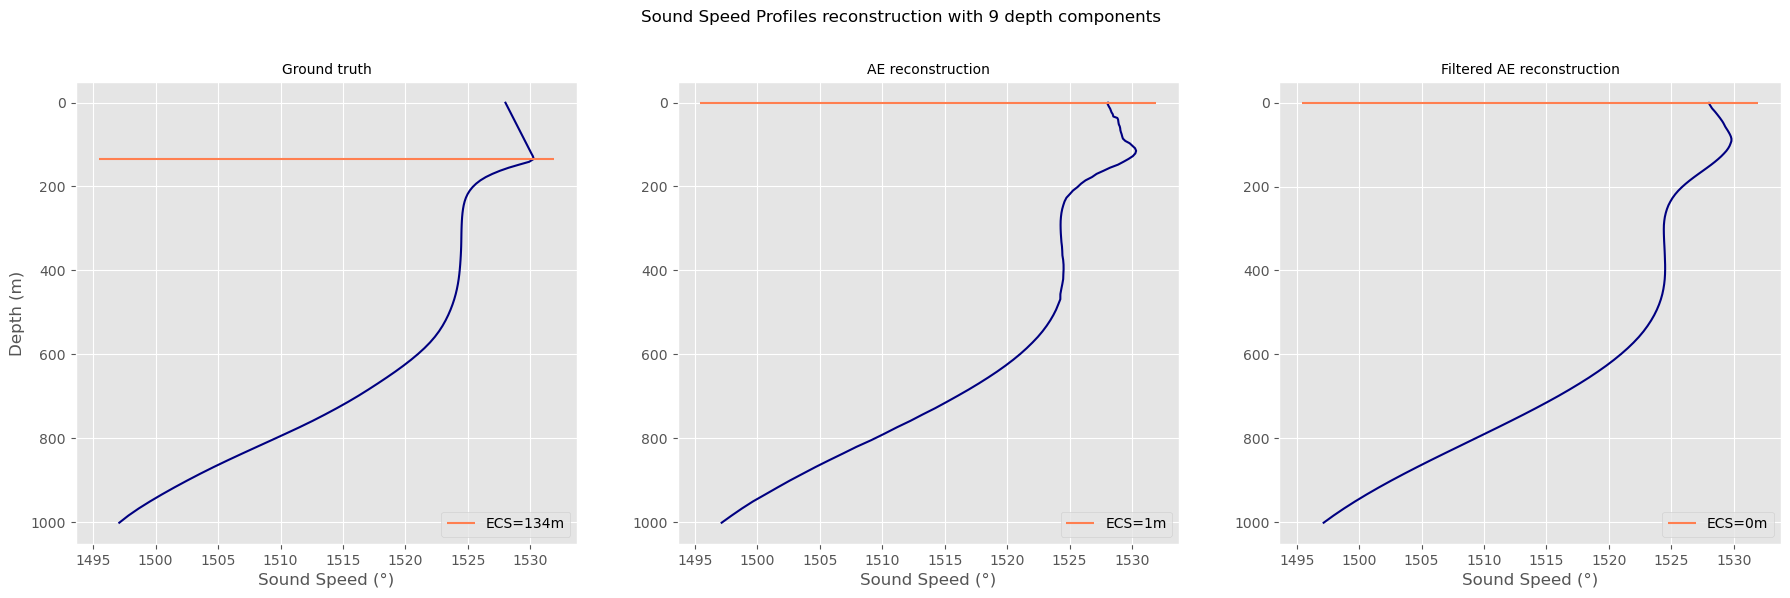

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(unorm_filtered_ssp_test[t,:,lat,lon], depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  ecs_pred_ae_filtered[t,lat,lon].detach().cpu().numpy() #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

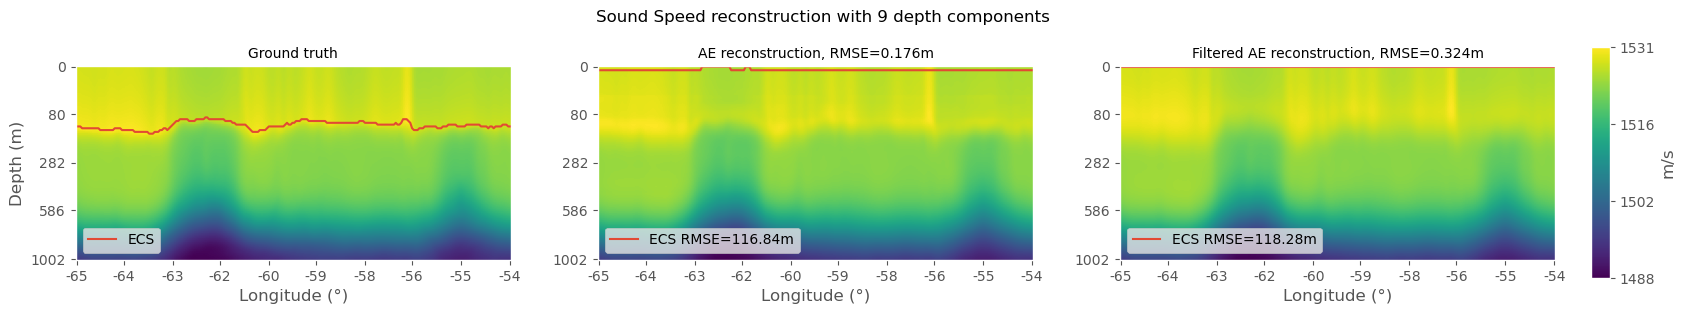

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)

# wavelets

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

ssp_flatten.shape

torch.Size([2073600, 107])

In [ ]:
ssp_flatten.detach().cpu().unsqueeze(1).unsqueeze(-1).repeat(1,1,1,4).shape

torch.Size([2073600, 1, 107, 4])

In [ ]:
wavelet = 'db1'
dwtf = DWTForward(J=1,mode='zero',wave=wavelet)  ##* mode="refleat" causes padding error
yl,yh = dwtf(ssp_flatten.detach().cpu().unsqueeze(1).unsqueeze(-1).repeat(1,1,1,3))

In [ ]:

dwtb = DWTInverse(mode="reflect",wave=wavelet)

high_compo = 1
filtered_high_pass = yh[:high_compo]  # Conserver les 2 premières composantes
for i in range(high_compo, len(yh)):
    filtered_high_pass.append(torch.zeros_like(yh[i])) 
    
filtered_yh = [torch.zeros_like(detail) for detail in yh]
ssp_flatten_filtered = dwtb((yl,filtered_high_pass))[:,0,:ssp_depth,0].squeeze()
ssp_flatten_filtered.shape

torch.Size([2073600, 107])

In [ ]:
ssp_3D_filtered = ssp_flatten_filtered.clone().detach().reshape(ssp_3D_shape).permute((0,3,1,2))  #ssp_3D_shape

unorm_filtered_ssp_test = unorm_ssp(ssp_3D_filtered,dm)
unorm_filtered_ssp_test.shape


(36, 107, 240, 240)

In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

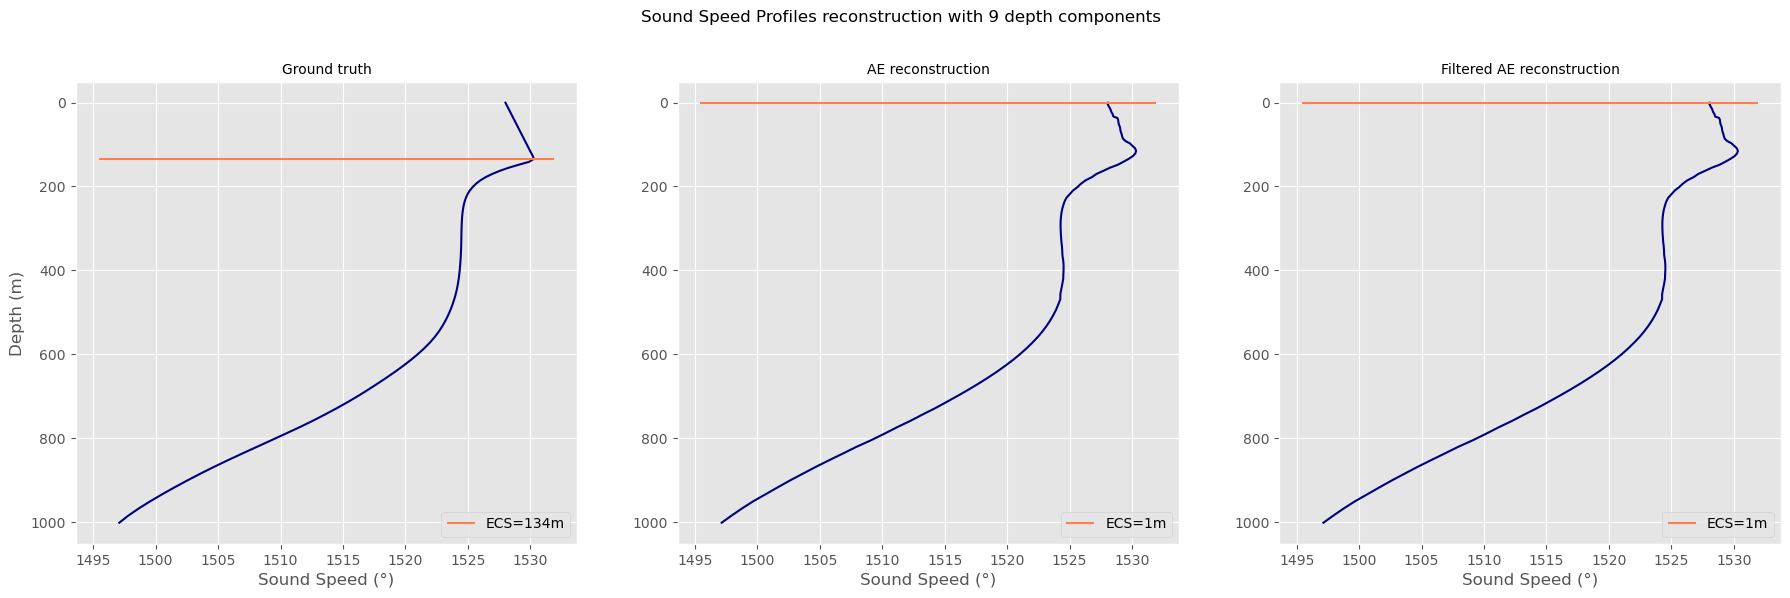

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(unorm_filtered_ssp_test[t,:,lat,lon], depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  ecs_pred_ae_filtered[t,lat,lon].detach().cpu().numpy() #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

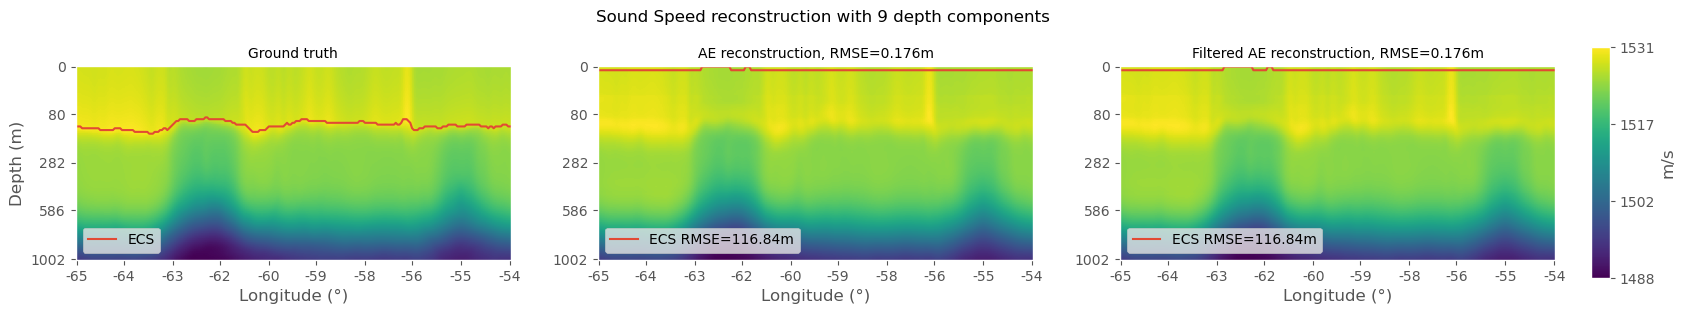

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)

# Scipy low band pass

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

ssp_flatten.shape

torch.Size([2073600, 107])

## signal frequency

In [ ]:
import numpy.fft as fft
spectrum = fft.fft(ssp_ae_unorm_test_arr[t,:,lat,lon])

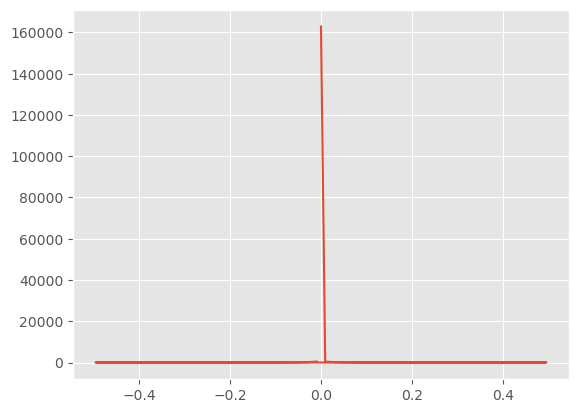

In [ ]:
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

In [ ]:
depth_linear = np.linspace(depth_array.min(), depth_array.max(), len(depth_array))

# Interpolation linéaire du signal
interp_func = interp1d(depth_array, ssp_ae_unorm_test_arr[t,:,lat,lon], kind='linear')
signal_linear = interp_func(depth_linear)

In [ ]:
signal_fft = scipy.fft.fft(signal_linear)
freqs = fftfreq(len(signal_linear), d=(depth_linear[1] - depth_linear[0]))

# Filtrer les fréquences positives
positive_freqs = freqs[freqs > 0]
amplitudes = np.abs(signal_fft[freqs > 0])

# Trouver la fréquence dominante
dominant_frequency = positive_freqs[np.argmax(amplitudes)]

In [ ]:
print("principal freq", dominant_frequency)
print("corresponding depth",1/dominant_frequency)

principal freq 0.0009887831671016429
corresponding depth 1011.3440775202882


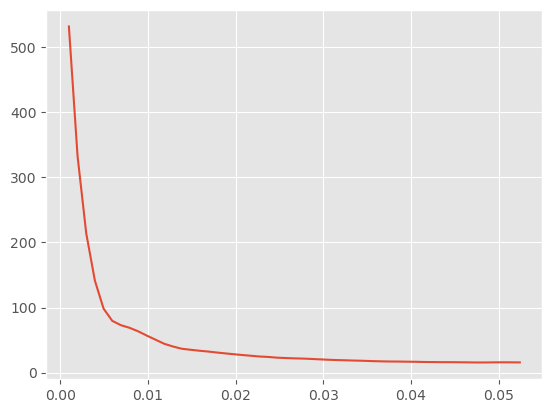

In [ ]:
plt.plot(positive_freqs,amplitudes)

mean frequency in the 300 meter

In [ ]:
i = 0
depth_diff = []
while depth_array[i] <=300:
     depth_diff.append(depth_array[i+1]-depth_array[i])
     i = i+1
mean_freq = 1/np.mean(depth_diff)

print("mean depth diff",np.mean(depth_diff))
print("mean freq",mean_freq)

mean depth diff 5.479656688136015
mean freq 0.18249318468529177


In [ ]:
fs =1/(depth_linear[1]-depth_linear[0])
print("mean linear depth diff",depth_linear[1]-depth_linear[0])
print("sampling freq",fs)


mean linear depth diff 9.451813808600823
sampling freq 0.1057997988798758


In [ ]:
#cutoff_freq = fs/2.01
cutoff_freq = 1/100

In [ ]:
low_band_filter = scipy.signal.butter(N=6, Wn=cutoff_freq, btype="lowpass", output="sos", fs=mean_freq)


In [ ]:
lon = 77
lon = 15

In [ ]:

filtered_signal = scipy.signal.sosfiltfilt(low_band_filter, ssp_ae_unorm_test_arr[t,:,lat,lon])


Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

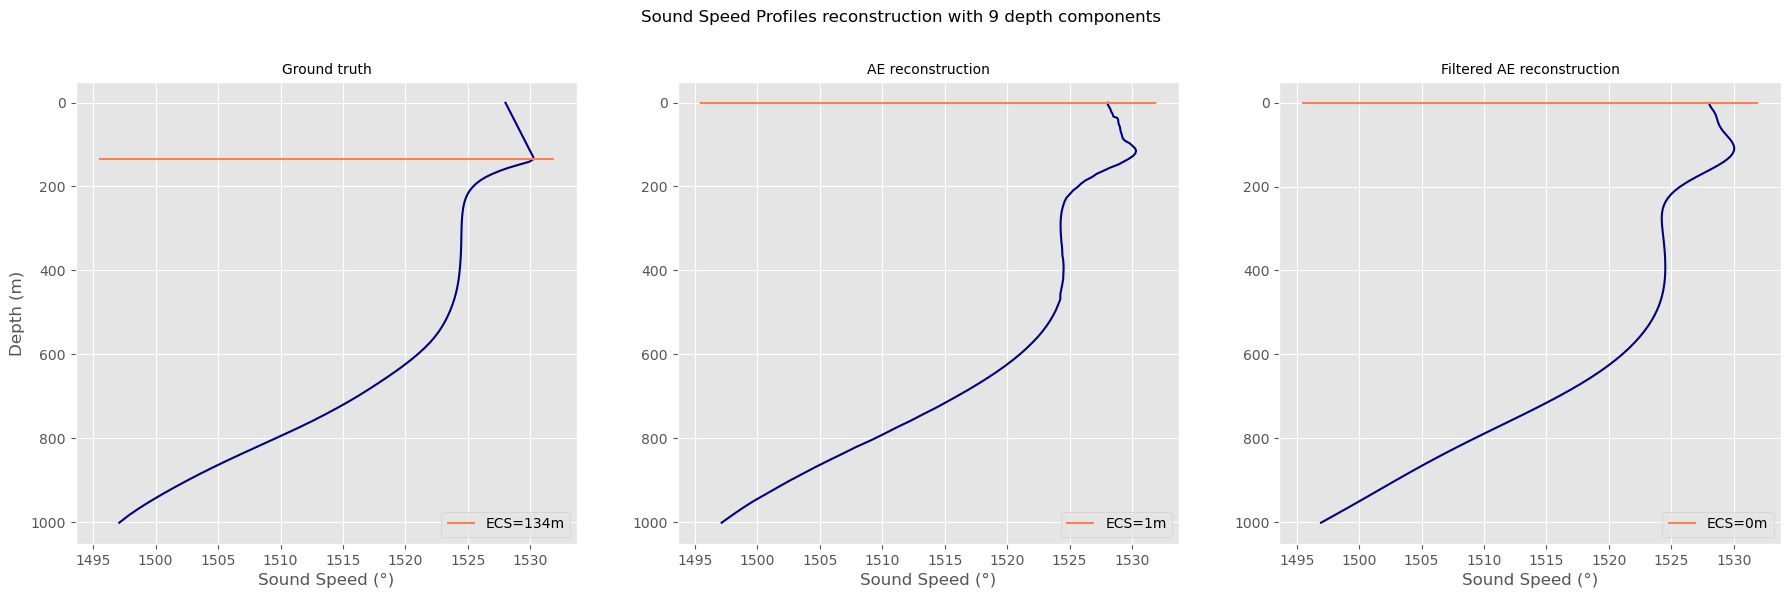

In [ ]:

fig,axs = plt.subplots(1,3,figsize=(22,6))



im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(filtered_signal, depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  get_ecs_ssp(filtered_signal,depth_array) #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

In [ ]:
filtered_signal = scipy.signal.sosfiltfilt(low_band_filter, signal_linear)



Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

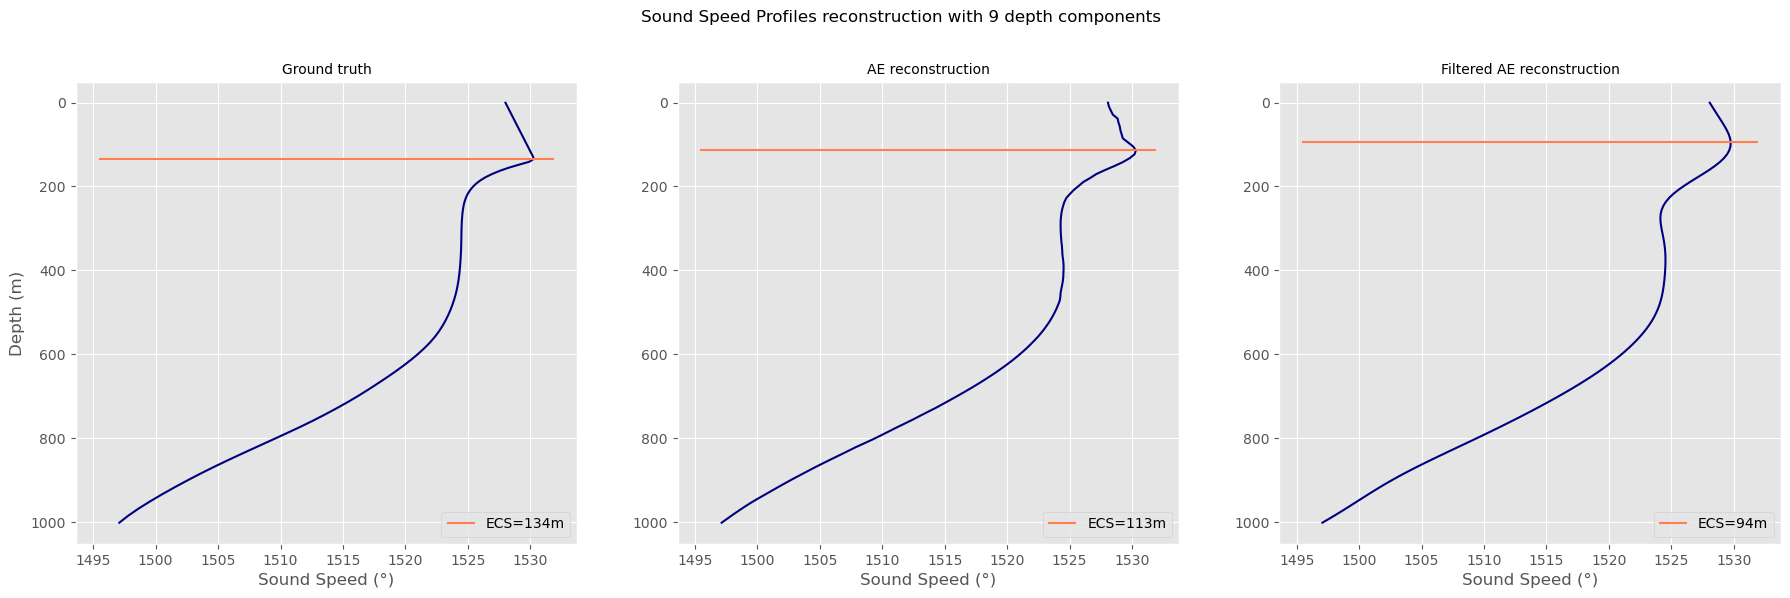

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(signal_linear, depth_linear, c ="navy")
im3 = axs[2].plot(filtered_signal, depth_linear, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(signal_linear,depth_linear)
ecs_pred_filtered_ssp =  get_ecs_ssp(filtered_signal,depth_linear) #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

In [ ]:
filtered_signal = scipy.signal.sosfiltfilt(low_band_filter, ssp_flatten.squeeze().detach().cpu().numpy(), axis = 1) #.reshape(ssp_3D_shape).permute((0,3,1,2))
filtered_signal = filtered_signal.reshape(ssp_3D_shape).transpose((0,3,1,2))
unorm_filtered_ssp_test = unorm_ssp(torch.tensor(filtered_signal.copy()) ,dm)


In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


In [ ]:
error = np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2,axis=0)


(error==error.max()).nonzero()

(array([211]),)

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

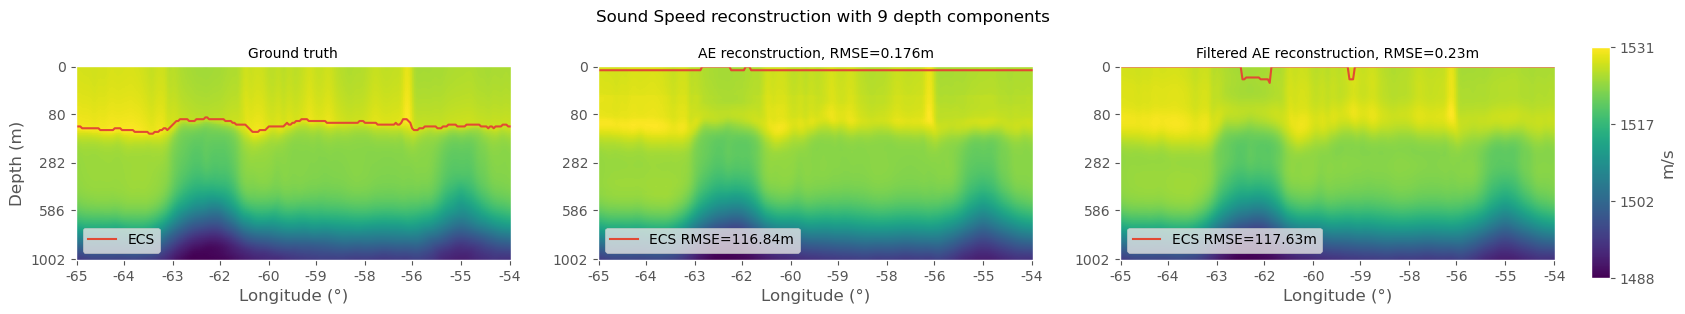

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)

In [ ]:
mean_freq

0.18249318468529177

In [ ]:
cutoff_freq

0.01

In [ ]:
low_band_filter = scipy.signal.butter(N=6, Wn=cutoff_freq, btype="lowpass", output="sos", fs=mean_freq)


# Scipy median filter

In [ ]:
ssp_3D = ssp_pred.permute((0,2,3,1))
ssp_3D_shape = ssp_3D.shape
ssp_depth = ssp_3D_shape[-1]

ssp_flatten = ssp_3D.reshape(-1,ssp_depth)

ssp_flatten.shape

torch.Size([2073600, 107])

In [ ]:
ssp_flatten_median = scipy.signal.medfilt(ssp_flatten.detach().cpu().numpy(), kernel_size=9)  #*the array will automatically be zero-padded.
ssp_3D_median = torch.tensor(ssp_flatten_median.reshape(ssp_3D_shape)).permute((0,3,1,2))

unorm_filtered_ssp_test = unorm_ssp(ssp_3D_median, dm)
unorm_filtered_ssp_test.shape


(36, 107, 240, 240)

In [ ]:
ecs_pred_ae_filtered = explicit_ecs(torch.tensor(unorm_filtered_ssp_test).float(),torch.tensor(depth_array).float()).to(device)


Text(0.5, 1, 'Sound Speed Profiles reconstruction with 9 depth components')

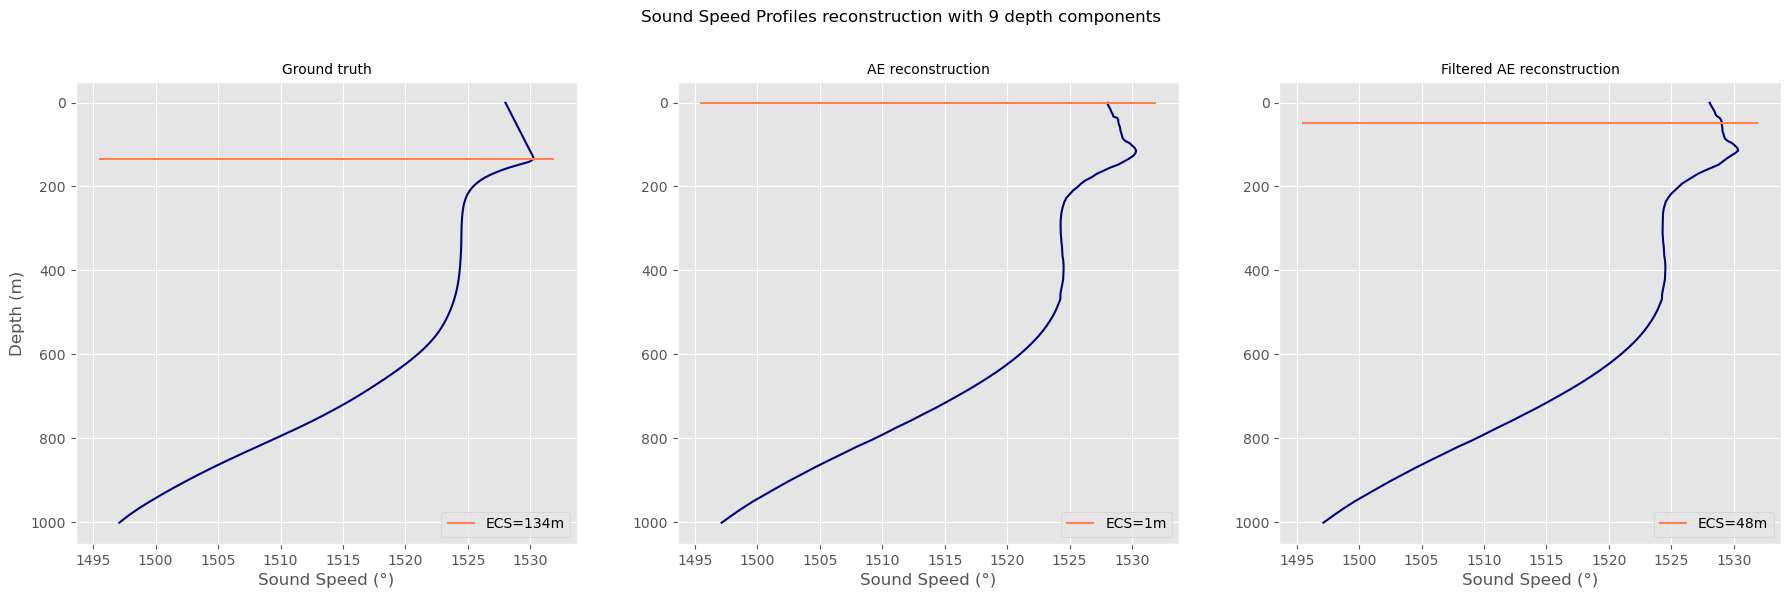

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(22,6))


im1 = axs[0].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  
im2 = axs[1].plot(ssp_ae_unorm_test_arr[t,:,lat,lon], depth_array, c ="navy")
im3 = axs[2].plot(unorm_filtered_ssp_test[t,:,lat,lon], depth_array, c ="navy")


xmin, xmax = axs[0].get_xlim()
ecs_truth_ssp = get_ecs_ssp(ssp_truth_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_ssp =  get_ecs_ssp(ssp_ae_unorm_test_arr[t,:,lat,lon],depth_array)
ecs_pred_filtered_ssp =  ecs_pred_ae_filtered[t,lat,lon].detach().cpu().numpy() #get_ecs_ssp(unorm_filtered_ssp_test[t,:,lat,lon],depth_array)


axs[0].hlines(ecs_truth_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth_ssp)}m", colors = "coral")
axs[1].hlines(ecs_pred_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ssp)}m", colors = "coral")
axs[2].hlines(ecs_pred_filtered_ssp, xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_filtered_ssp)}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title("AE reconstruction", fontsize = 10)
axs[2].set_title("Filtered AE reconstruction", fontsize = 10)



axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction with {n_components} depth components",x = 0.5, y = 1)

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

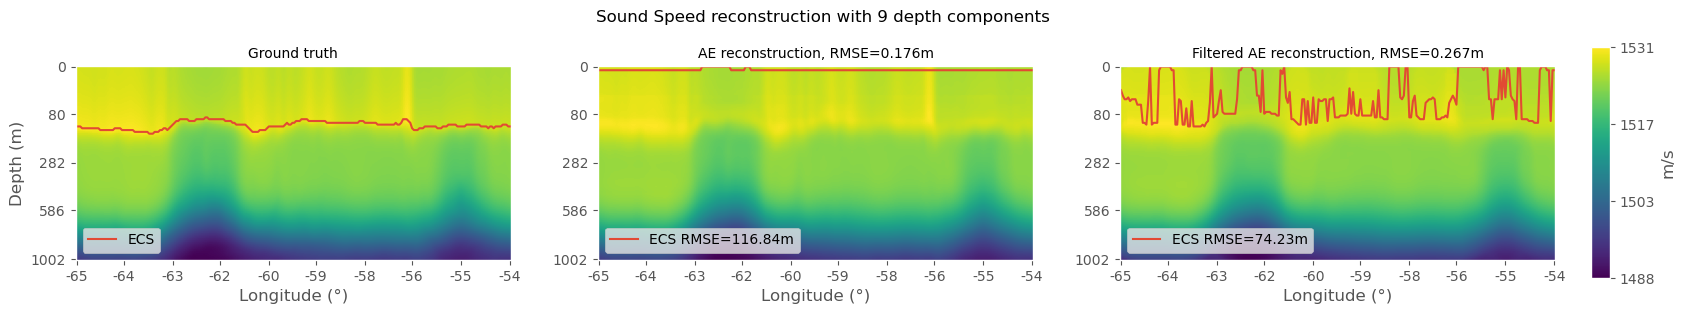

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})
ssp_ae_unorm_test_arr
im1 = axs[0].imshow(ssp_truth_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(ssp_ae_unorm_test_arr[t,:,lat,:], cmap=cmap, aspect = "equal")
#im3 = axs[2].imshow(filtered_2D_ssp, cmap=cmap, aspect = "equal")*
im3 = axs[2].imshow(unorm_filtered_ssp_test[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]



#ecs_pred_ae_filtered = get_ecs_ssp_2D(filtered_2D_ssp,depth_array)


indices_ecs_truth = np.searchsorted(depth_array, ecs_truth[t,lat,:].detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae[t,lat,:].detach().cpu().numpy())
indices_ecs_ae_filtered = np.searchsorted(depth_array, ecs_pred_ae_filtered[t,lat,:].detach().cpu().numpy())

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_ae, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae[t,lat,:])**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae_filtered, 
            label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth[t,lat,:]-ecs_pred_ae_filtered[t,lat,:])**2)).item(),2)}m")

for ax in axs[:]:
    ax.set_yticks(y_tick_indices)
    ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-ssp_ae_unorm_test_arr[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)
axs[2].set_title(f"Filtered AE reconstruction, RMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr[t,:,lat,:]-unorm_filtered_ssp_test[t,:,lat,:])**2)),3)}m",fontsize=10)#/np.sum(ssp_truth_unorm_test_arr[t,:,lat,:]**2))*100,8)}%", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)